In [10]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import pickle

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv( "/home/bautista/Datos/Machine-Learning-Datos/FeatureEngineering/df_time_series.csv" )
df = df.drop(columns = {'Unnamed: 0', 'Delivery_Year', 'Delivery_Quarter'})
df

,Region,Total_Amount,TRF,Opportunity_Owner,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision,Promedio_Region_Por_Quarter,Promedio_Owner_Por_Year_And_Quarter,Lag_1,Delta
0,EMEA,13.271783,1,Other,0,1,0,13.892824,13.271783,NaN,17.330865
1,EMEA,12.753460,1,Other,1,1,0,13.912927,12.753460,13.271783,17.306318
2,EMEA,17.332958,80,Other,1,1,0,13.895475,17.332958,12.753460,18.011205
3,APAC,13.386359,2,Other,0,0,0,14.012659,13.386359,17.332958,0.000000
4,APAC,11.377793,0,Person_Name_11,1,1,1,14.255779,12.723426,NaN,17.323551
...,...,...,...,...,...,...,...,...,...,...,...
16767,Americas,14.477339,6,Person_Name_8,1,1,1,14.621714,16.483576,16.318135,17.377829
16768,Americas,14.033311,4,Person_Name_8,1,1,1,14.621714,16.483576,16.318135,17.377829
16769,Americas,14.477339,6,Person_Name_8,1,1,1,14.621714,16.483576,16.318135,17.377829
16770,Americas,18.017027,195,Person_Name_8,1,1,0,14.621714,16.483576,16.318135,17.377829


In [12]:
df = df.fillna(0)

In [13]:
df.describe()

,Total_Amount,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision,Promedio_Region_Por_Quarter,Promedio_Owner_Por_Year_And_Quarter,Lag_1,Delta
count,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000
mean,10.470044,2.281660,0.585440,0.807834,0.568030,13.255775,12.244222,11.541450,17.309752
std,3.308478,12.084678,0.492661,0.394014,0.495365,1.329157,2.325201,3.965941,0.148853
min,-4.605170,0.000000,0.000000,0.000000,0.000000,11.058881,3.806662,0.000000,0.000000
25%,8.465995,0.000000,0.000000,1.000000,0.000000,11.464494,10.971975,10.113876,17.303476
50%,11.253377,0.000000,1.000000,1.000000,1.000000,13.892824,12.847837,12.894433,17.313452
75%,12.582682,1.000000,1.000000,1.000000,1.000000,14.012659,14.000724,14.075266,17.319557
max,19.568083,500.000000,1.000000,1.000000,1.000000,15.245204,19.568083,17.528668,19.542568


# Encode

In [14]:
Mean_encoded_subject_region = df.groupby(['Region'])['Decision'].mean().to_dict() 

df['Region'] =  df['Region'].map(Mean_encoded_subject_region)

#Mean_encoded_subject_quarter = df.groupby(['Delivery_Quarter'])['Decision'].mean().to_dict() 

#df['Delivery_Quarter'] =  df['Delivery_Quarter'].map(Mean_encoded_subject_quarter)

Mean_encoded_subject_owner = df.groupby(['Opportunity_Owner'])['Decision'].mean().to_dict() 

df['Opportunity_Owner'] =  df['Opportunity_Owner'].map(Mean_encoded_subject_owner)

# Split

In [15]:
X_test = df.tail(math.floor(df.shape[0]*0.20)).drop(columns = {'Decision'})
y_test = df.tail(math.floor(df.shape[0]*0.20))['Decision']
X_train = df.head(round(df.shape[0]*0.80)).drop(columns = {'Decision'})
y_train = df.head(round(df.shape[0]*0.80))['Decision']
X_train

,Region,Total_Amount,TRF,Opportunity_Owner,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Promedio_Region_Por_Quarter,Promedio_Owner_Por_Year_And_Quarter,Lag_1,Delta
0,0.532241,13.271783,1,0.000000,0,1,13.892824,13.271783,0.000000,17.330865
1,0.532241,12.753460,1,0.000000,1,1,13.912927,12.753460,13.271783,17.306318
2,0.532241,17.332958,80,0.000000,1,1,13.895475,17.332958,12.753460,18.011205
3,0.586506,13.386359,2,0.000000,0,0,14.012659,13.386359,17.332958,0.000000
4,0.586506,11.377793,0,0.342105,1,1,14.255779,12.723426,0.000000,17.323551
...,...,...,...,...,...,...,...,...,...,...
13413,0.586506,13.564794,2,0.820809,1,1,14.255779,12.688738,12.098791,17.317810
13414,0.586506,14.414472,5,0.820809,0,0,13.802683,12.847837,12.688738,17.315139
13415,0.586506,12.565813,1,0.820809,0,0,13.802683,12.847837,12.688738,17.315139
13416,0.586506,11.964511,0,0.820809,0,1,13.802683,12.847837,12.688738,17.315139


# Regresion

In [16]:
import sklearn as sk
import sklearn.neural_network


lr = 0.001           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

# Creamos el objeto del modelo de red neuronal multicapa.
modelRegresor = sk.neural_network.MLPRegressor(solver='adam', 
                                     activation = 'logistic',
                                     learning_rate_init=lr,
                                     hidden_layer_sizes=tuple(nn[1:]),
                                     verbose=True,
                                     n_iter_no_change=1000,
                                     batch_size = 64)

In [17]:
modelRegresor.fit(X_train, y_train)

Iteration 1, loss = 0.12050319
Iteration 2, loss = 0.10565436
Iteration 3, loss = 0.09373956
Iteration 4, loss = 0.08791164
Iteration 5, loss = 0.08362575
Iteration 6, loss = 0.07923280
Iteration 7, loss = 0.07499405
Iteration 8, loss = 0.07212088
Iteration 9, loss = 0.07041054
Iteration 10, loss = 0.06898496
Iteration 11, loss = 0.06834676
Iteration 12, loss = 0.06761108
Iteration 13, loss = 0.06705684
Iteration 14, loss = 0.06678785
Iteration 15, loss = 0.06643210
Iteration 16, loss = 0.06588361
Iteration 17, loss = 0.06576038
Iteration 18, loss = 0.06555908
Iteration 19, loss = 0.06521264
Iteration 20, loss = 0.06531715
Iteration 21, loss = 0.06493530
Iteration 22, loss = 0.06485581
Iteration 23, loss = 0.06457137
Iteration 24, loss = 0.06460594
Iteration 25, loss = 0.06455446
Iteration 26, loss = 0.06450708
Iteration 27, loss = 0.06468911
Iteration 28, loss = 0.06451903
Iteration 29, loss = 0.06429483
Iteration 30, loss = 0.06424854
Iteration 31, loss = 0.06408402
Iteration 32, los

MLPRegressor(activation='logistic', batch_size=64,
             hidden_layer_sizes=(16, 8, 1), n_iter_no_change=1000,
             verbose=True)

In [18]:
LinReg_pred = modelRegresor.predict(X_test)

In [19]:
probando = pd.DataFrame()
probando['target'] = LinReg_pred
probando.describe()

,target
count,3354.000000
mean,0.517195
std,0.305681
min,-0.031517
25%,0.233700
50%,0.499161
75%,0.811265
max,1.036068


In [20]:
modelRegresor.score(X_test, y_test)

0.1662372843243891

In [21]:
loss = log_loss(y_test  , LinReg_pred)
print(f"Log loss is {loss}")

Log loss is 0.603955405288283


In [22]:
#pickle.dump(modelRegresor, open('modeloRegresorRN.p', 'wb'))

# Kaggle

In [23]:
DataFrame_test = pd.read_csv( "/home/bautista/Datos/Machine-Learning-Datos/FeatureEngineering/df_time_series_test.csv" )
DataFrame_test

,Unnamed: 0,Opportunity_ID,Region,Total_Amount,TRF,Delivery_Year,Opportunity_Owner,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Promedio_Region_Por_Quarter,Promedio_Owner_Por_Year_And_Quarter,Lag_1,Delta
0,171,10792,EMEA,12.087389,1,2019,Person_Name_13,Q1,1,1,11.753909,11.001991,NaN,11.000704
1,226,10806,EMEA,10.325097,0,2019,Person_Name_13,Q1,0,1,11.753909,11.001991,NaN,11.000704
2,238,10812,EMEA,11.479095,0,2019,Person_Name_13,Q1,1,1,11.753909,11.001991,NaN,11.000704
3,270,10836,EMEA,10.155219,0,2019,Person_Name_13,Q1,1,1,11.753909,11.001991,NaN,11.000704
4,282,10845,EMEA,9.975017,0,2019,Person_Name_13,Q1,1,1,11.753909,11.001991,NaN,11.000704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2519,12347,Americas,15.340732,12,2020,Person_Name_9,Q2,1,1,13.560399,15.849836,2.081695,15.849825
1563,2520,12348,Americas,16.193551,28,2020,Person_Name_9,Q2,1,1,13.560399,15.849836,2.081695,15.849825
1564,2521,12349,Americas,15.831542,20,2020,Person_Name_9,Q2,1,1,13.560399,15.849836,2.081695,15.849825
1565,2522,12350,Americas,16.193551,28,2020,Person_Name_9,Q3,1,1,14.756877,16.193551,2.081695,16.193543


In [24]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test['Opportunity_ID']
DataFrame_test = DataFrame_test.drop(columns = {'Opportunity_ID', 'Unnamed: 0', 'Delivery_Year', 'Delivery_Quarter'}).fillna(0)
DataFrame_test

,Region,Total_Amount,TRF,Opportunity_Owner,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Promedio_Region_Por_Quarter,Promedio_Owner_Por_Year_And_Quarter,Lag_1,Delta
0,EMEA,12.087389,1,Person_Name_13,1,1,11.753909,11.001991,0.000000,11.000704
1,EMEA,10.325097,0,Person_Name_13,0,1,11.753909,11.001991,0.000000,11.000704
2,EMEA,11.479095,0,Person_Name_13,1,1,11.753909,11.001991,0.000000,11.000704
3,EMEA,10.155219,0,Person_Name_13,1,1,11.753909,11.001991,0.000000,11.000704
4,EMEA,9.975017,0,Person_Name_13,1,1,11.753909,11.001991,0.000000,11.000704
...,...,...,...,...,...,...,...,...,...,...
1562,Americas,15.340732,12,Person_Name_9,1,1,13.560399,15.849836,2.081695,15.849825
1563,Americas,16.193551,28,Person_Name_9,1,1,13.560399,15.849836,2.081695,15.849825
1564,Americas,15.831542,20,Person_Name_9,1,1,13.560399,15.849836,2.081695,15.849825
1565,Americas,16.193551,28,Person_Name_9,1,1,14.756877,16.193551,2.081695,16.193543


# Encoding

In [25]:
DataFrame_test['Region'] =  DataFrame_test['Region'].map(Mean_encoded_subject_region) 

#DataFrame_test['Delivery_Quarter'] =  DataFrame_test['Delivery_Quarter'].map(Mean_encoded_subject_quarter)

DataFrame_test['Opportunity_Owner'] =  DataFrame_test['Opportunity_Owner'].map(Mean_encoded_subject_owner)
DataFrame_test = DataFrame_test.fillna(0.406068)

In [26]:
DataFrame_test.isnull().sum()

Region                                 0
Total_Amount                           0
TRF                                    0
Opportunity_Owner                      0
Pricing, Delivery_Terms_Approved       0
Pricing, Delivery_Terms_Quote_Appr     0
Promedio_Region_Por_Quarter            0
Promedio_Owner_Por_Year_And_Quarter    0
Lag_1                                  0
Delta                                  0
dtype: int64

# Prediction

In [27]:
pred_posta = modelRegresor.predict(DataFrame_test)

In [28]:
subir['target'] = pred_posta
subir.set_index('Opportunity_ID', inplace = True)
subir

,target
Opportunity_ID,
10792,0.416707
10806,0.464953
10812,0.495961
10836,0.668293
10845,0.693702
...,...
12347,0.208250
12348,0.072086
12349,0.225619


In [29]:
subir.describe()

,target
count,1567.000000
mean,0.294528
std,0.189018
min,-0.034428
25%,0.147671
50%,0.244609
75%,0.396420
max,1.006168


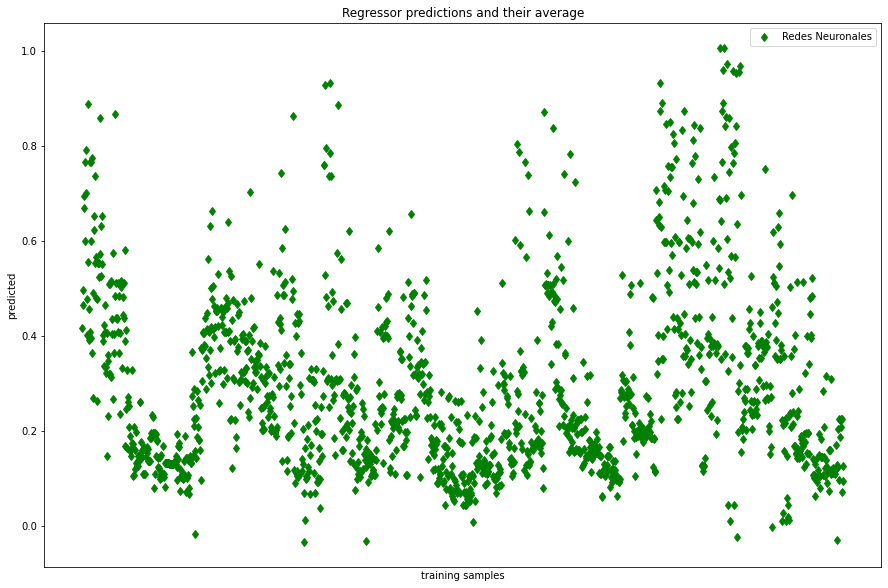

In [30]:
plt.figure(figsize=(15,10))

plt.plot(pred_posta, 'gd', label='Redes Neuronales')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')


plt.show()

In [31]:
#subir.to_csv('RedesNeuronales_Entrega_8.csv')